<h1><center> Scraping and Analysis of Rohlik.cz </h1></center>

#### <center> Project for Data Processing in Python <div style="line-height:120%;">  <br> </div> Petra Aschermannová, Aneta Pinteková <div style="line-height:120%;">  <br> </div> Institute of Economic Studies, Summer semester 2019/2020 

In [2]:
import pandas as pd
import numpy as np
import requests
from lxml import html
import xml.etree.ElementTree as et
from decimal import Decimal
from ratelimit import limits, sleep_and_retry
import matplotlib.pyplot as plt

## Part I. - Scraping Rohlik website ##

In [2]:
# ------------------ GET PRODUCT URLs
# define url - site map of all the products
url = 'https://www.rohlik.cz/sitemap.xml'

# create http response object
resp = requests.get(url)

# parse xml
tree = et.fromstring(resp.content)
child = tree.getchildren()

# extract product URLs
products = [i[0].text for i in child]

# convert to panda series (it supports regex)
products = pd.Series(products)

# use regex to extract URLs that contain products with their prices - defined as 7 numbers and text, divided by '-'
products = products[products.str.contains('https://www.rohlik.cz/[0-9]{1,8}-*')]

C:\Users\petra\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  # Remove the CWD from sys.path while we load stuff.


In [3]:
products[:10]

0    https://www.rohlik.cz/1296727-nivea-men-silver...
1    https://www.rohlik.cz/1296729-nivea-for-men-in...
2    https://www.rohlik.cz/1296749-nivea-intimo-sen...
3    https://www.rohlik.cz/1296751-nivea-creme-care...
4    https://www.rohlik.cz/1296953-odol-stoma-parad...
5    https://www.rohlik.cz/1296965-racio-chlebicky-...
6    https://www.rohlik.cz/1296977-nescafe-dolce-gu...
7    https://www.rohlik.cz/1297003-alpro-kokosovy-n...
8    https://www.rohlik.cz/1297005-alpro-sojovy-nap...
9    https://www.rohlik.cz/1297007-wasa-delikatess-...
dtype: object

In [4]:
# ------------------ TRY THE SCRIPT FOR SCRAPING PRICES ON 1 PRODUCT:
prod_1 = products[160]
pageContent = requests.get(prod_1).content
tree = html.fromstring(pageContent)

prod_name = tree.xpath('//*[@class="redirect_link disabled"]//text()')

nopromo = tree.xpath('//*[@class="currentPrice"]//text()')

if(len(nopromo) == 0):
  nopromo = tree.xpath('//*//del/text()')

if(len(nopromo) == 2 and ('cca' in nopromo[0])):
  nopromo = nopromo[1]

if((isinstance(nopromo, (list,)) and len(nopromo) > 1) or (len(nopromo) == 0)):
    nopromo = np.nan

promo = tree.xpath('//*[@class="actionPrice"]//text()')

if(len(promo) == 0):
    promo = np.nan 

prod_quantity = tree.xpath('//*[@class="detailQuantity"]//text()')
if(len(prod_quantity) == 0):
    prod_quantity = np.nan 

prod_category = tree.xpath('//*[contains(@class, "redirect_link") and contains(@href, "/c")]//text()')
prod_cat = '-'.join(prod_category)

# create dictionary from scraped data: 
data = {'Product name': prod_name,
'Regular price': nopromo,
'Promo price': promo, 
'Quantity': prod_quantity, 
'Category': prod_cat}

# if df does not exist, create it: 
df = pd.DataFrame(data)
# else append the data to the existing data frame:
#df = df.append(pd.DataFrame(data))

In [5]:
df

,Product name,Regular price,Promo price,Quantity,Category
0,HiPP Bio Boloňské lasagne,"69,90 Kč","59,90 Kč",250 g,Příkrmy-Masové


In [ ]:
# ----------- FOR LOOP 
df = pd.DataFrame()

for x in products[50:70]:
  pageContent = requests.get(x).content
  tree = html.fromstring(pageContent)
  prod_name = tree.xpath('//*[@class="redirect_link disabled"]//text()')

  nopromo = tree.xpath('//*[@class="currentPrice"]//text()')

  if(len(nopromo) == 0):
    nopromo = tree.xpath('//*[@class="actionPrice"]/del//text()')

  if(len(nopromo) == 2 and ('cca' in nopromo[0])):
    nopromo = nopromo[1]

  promo = tree.xpath('//*[@class="actionPrice"]//text()')

  if(len(promo) == 0):
    promo = np.nan 
  
  if(len(nopromo) == 0):
    nopromo = np.nan

  prod_quantity = tree.xpath('//*[@class="detailQuantity"]//text()')
  if(len(prod_quantity) == 0):
    prod_quantity = np.nan

  prod_category = tree.xpath('//*[@class="sc-1ywzolw-1 jQxyMp"]//text()')
  prod_cat = '-'.join(prod_category)

  data = {'Product name': prod_name,
          'Regular price': nopromo, 
          'Promo price': promo,
          'Quantity': prod_quantity, 
          'Category': prod_cat}
  df = df.append(pd.DataFrame(data))

In [15]:
# ----------- DEFINE A FUNCTION TO EXTRACT DATA
@limits(calls = 10, period = 60) # set limit on scraping: 10 products per minute ~ 25.5 hours of scraping
@sleep_and_retry 
def extract_rohlik(x):
    pageContent = requests.get(x).content
    tree = html.fromstring(pageContent)
    prod_name = tree.xpath('//*[@class="redirect_link disabled"]//text()')

    nopromo = tree.xpath('//*[@class="currentPrice"]//text()')

    if(len(nopromo) == 0):
      nopromo = tree.xpath('//*//del/text()')

    if(len(nopromo) == 2 and ('cca' in nopromo[0])):
      nopromo = nopromo[1]
    
    if((isinstance(nopromo, (list,)) and len(nopromo) > 1) or (len(nopromo) == 0)):
      nopromo = np.nan

    promo = tree.xpath('//*[@class="actionPrice"]//text()')

    if(len(promo) == 0):
      promo = np.nan 

    prod_quantity = tree.xpath('//*[@class="detailQuantity"]//text()')
    if(len(prod_quantity) == 0):
      prod_quantity = np.nan 

    prod_category = tree.xpath('//*[contains(@class, "redirect_link") and contains(@href, "/c")]//text()')
    prod_cat = '-'.join(prod_category)

    data = {'Product name': prod_name,
            'Regular price': nopromo, 
            'Promo price': promo,
            'Quantity': prod_quantity, 
            'Category': prod_cat, 
            'URL': x}
    return(pd.DataFrame(data))

In [17]:
# try the function:
a = [extract_rohlik(x) for x in products[160:170]]
pd.concat(a, axis = 0)

,Product name,Regular price,Promo price,Quantity,Category,URL
0,HiPP Bio Boloňské lasagne,"69,90 Kč","59,90 Kč",250 g,Příkrmy-Masové,https://www.rohlik.cz/1298009-hipp-bio-bolonsk...
0,HiPP Bio Jablečno - hroznová šťáva,"34,90 Kč",NaN,200 ml,Nápoje-Ovocné šťávy,https://www.rohlik.cz/1298011-hipp-bio-jablecn...
0,HiPP Bio Hrušková šťáva,"34,90 Kč",NaN,200 ml,Nápoje-Ovocné šťávy,https://www.rohlik.cz/1298013-hipp-bio-hruskov...
0,HiPP BIO Meruňkovo-Hruškový nektar,"34,90 Kč",NaN,200 ml,Nápoje-Ovocné šťávy,https://www.rohlik.cz/1298015-hipp-bio-merunko...
0,HiPP Bio Švestkový nektar,"34,90 Kč",NaN,200 ml,Nápoje-Ovocné šťávy,https://www.rohlik.cz/1298017-hipp-bio-svestko...
0,HiPP Bio Šťáva z červených plodů ovoce,"74,90 Kč",NaN,500 ml,Nápoje-Ovocné šťávy,https://www.rohlik.cz/1298019-hipp-bio-stava-z...
0,HiPP Bio Jablečno - hroznová šťáva,"74,90 Kč",NaN,500 ml,Nápoje-Ovocné šťávy,https://www.rohlik.cz/1298021-hipp-bio-jablecn...
0,HiPP Bio Jablečná šťáva s fenyklovým čajem,"49,90 Kč","46,90 Kč",500 ml,Nápoje-Ovocné šťávy,https://www.rohlik.cz/1298023-hipp-bio-jablecn...
0,HiPP Mama Nápoj v prášku pro kojící matky,"139,90 Kč",NaN,200 g,Pro maminky a těhotné-Kojící čaje a nápoje,https://www.rohlik.cz/1298025-hipp-mama-napoj-...
0,HiPP Mamasanft Masážní olej na strie,"249,90 Kč",NaN,100 ml,"Pro maminky a těhotné-Krémy na strie, celulitidu",https://www.rohlik.cz/1298029-hipp-mamasanft-m...


In [ ]:
# Data storing with try except
all_product_data = pd.DataFrame([])

for x in products[:100]:
    try:
        d = extract_rohlik(x) 
        all_product_data = all_product_data.append(d)
        
    except Exception as e:
        # If there is an error, store the error message and corresponding url to the dataframe
        error_frame = pd.DataFrame([[str(e), x]], columns = ['Error', 'URL'])
        all_product_data = all_product_data.append(error_frame)

all_product_data

In [ ]:
# Export data: 
all_product_data.to_csv('data_week_4a.csv', sep = ';', encoding='utf-8')

In [6]:
# Try to read the data (see if encoding works properly): 
try_data = pd.read_csv('data_week_4a.csv', sep = ';')
try_data.head()

,Unnamed: 0,Product name,Regular price,Promo price,Quantity,Category,URL
0,0,Nivea Men Silver Protect Kuličkový antiperspirant,"89,90 Kč","84,90 Kč",50 ml,Pánské-Kuličkové,https://www.rohlik.cz/1296727-nivea-men-silver...
1,0,Nivea For Men Invisible for black & white anti...,NaN,NaN,150 ml,Pánské-Ve spreji,https://www.rohlik.cz/1296729-nivea-for-men-in...
2,0,Nivea Intimo Sensitive sprchová emulze pro int...,"119,90 Kč",NaN,250 ml,Dámské hygienické potřeby-Intimní hygiena,https://www.rohlik.cz/1296749-nivea-intimo-sen...
3,0,Nivea Creme Care tekuté mýdlo na ruce,"59,90 Kč",NaN,250 ml,Mýdla-Tekutá,https://www.rohlik.cz/1296751-nivea-creme-care...
4,0,Odol Stoma Paradentol Ústní voda pro zdravé dásně,"89,90 Kč","84,90 Kč",500 ml,Ústní hygiena-Ústní vody,https://www.rohlik.cz/1296953-odol-stoma-parad...


# Part II. - Data Analysis #

### LOADING AND PREPARING THE DATA ###

In [3]:
### Data load ###

# Set the number of weeks in which data were scraped
n_of_weeks = 3

# Initialize empty dataframe with time column
data = pd.DataFrame(columns = ['Time'])

# Load parts a,b for every week, add time, append to the final dataframe
for x in range(1, n_of_weeks + 1):
    
    a = pd.read_csv('data_week_' + str(x) + 'a.csv', sep = ';', encoding = 'utf8')
    b = pd.read_csv('data_week_' + str(x) + 'b.csv', sep = ';', encoding = 'utf8')
    a['Time'] = x
    b['Time'] = x
    
    data = data.append(a, ignore_index = True, sort = True).append(b, ignore_index = True, sort = True)

In [4]:
# Check
data.head(3)

,Category,Error,Product name,Promo price,Quantity,Regular price,Time,URL,Unnamed: 0
0,Pánské-Kuličkové,NaN,Nivea Men Silver Protect Kuličkový antiperspirant,"84,90 Kč",50 ml,"89,90 Kč",1,https://www.rohlik.cz/1296727-nivea-men-silver...,0.0
1,Pánské-Ve spreji,NaN,Nivea For Men Invisible for black & white anti...,"84,90 Kč",150 ml,"89,90 Kč",1,https://www.rohlik.cz/1296729-nivea-for-men-in...,0.0
2,Dámské hygienické potřeby-Intimní hygiena,NaN,Nivea Intimo Sensitive sprchová emulze pro int...,NaN,250 ml,"119,90 Kč",1,https://www.rohlik.cz/1296749-nivea-intimo-sen...,0.0


In [5]:
# Dropping unnecessary columns
data = data[['Category', 'Product name', 'Regular price', 'Promo price', 'Quantity', 'Time']]

# Splitting category column into main category and subcategory
data[['Category', 'Subcategory']] = data.Category.str.split("-", n = 1, expand = True)

In [6]:
# Check
data.head(3)

,Category,Product name,Regular price,Promo price,Quantity,Time,Subcategory
0,Pánské,Nivea Men Silver Protect Kuličkový antiperspirant,"89,90 Kč","84,90 Kč",50 ml,1,Kuličkové
1,Pánské,Nivea For Men Invisible for black & white anti...,"89,90 Kč","84,90 Kč",150 ml,1,Ve spreji
2,Dámské hygienické potřeby,Nivea Intimo Sensitive sprchová emulze pro int...,"119,90 Kč",NaN,250 ml,1,Intimní hygiena


In [7]:
# Converting prices to numbers

# a) Trim "Kč" 
data['Promo price'] = data['Promo price'].str.replace('Kč', '')
data['Regular price'] = data['Regular price'].str.replace('Kč', '')

# b) Decimal point instead of comma
data['Promo price'] = data['Promo price'].str.replace(',', '.')
data['Regular price'] = data['Regular price'].str.replace(',', '.')

# c) Remove thousand separator in numbers
data['Promo price'].replace('\s+', '', regex = True, inplace = True)
data['Regular price'].replace('\s+', '', regex = True, inplace = True)

# d) Remove all non-decimal characters
data['Promo price'].replace(r'[^\d.]+', '', regex = True, inplace = True)
data['Regular price'].replace(r'[^\d.]+', '', regex = True, inplace = True)

# e) Convert to float type
data['Promo price'] = data['Promo price'].astype('float')
data['Regular price'] = data['Regular price'].astype('float')

# f) Round to 1 decimal place
data = data.round(1)

# g) Remove products with price = 0 (1 product only)
data = data[data["Regular price"] != 0.0]

In [8]:
# Check
print(data.dtypes)
data.head(10)

Category          object
Product name      object
Regular price    float64
Promo price      float64
Quantity          object
Time              object
Subcategory       object
dtype: object


,Category,Product name,Regular price,Promo price,Quantity,Time,Subcategory
0,Pánské,Nivea Men Silver Protect Kuličkový antiperspirant,89.9,84.9,50 ml,1,Kuličkové
1,Pánské,Nivea For Men Invisible for black & white anti...,89.9,84.9,150 ml,1,Ve spreji
2,Dámské hygienické potřeby,Nivea Intimo Sensitive sprchová emulze pro int...,119.9,NaN,250 ml,1,Intimní hygiena
3,Mýdla,Nivea Creme Care tekuté mýdlo na ruce,59.9,NaN,250 ml,1,Tekutá
4,Ústní hygiena,Odol Stoma Paradentol Ústní voda pro zdravé dásně,89.9,84.9,500 ml,1,Ústní vody
5,Racio a Knäckebrot,RACIO Chlebíčky rýžové,13.9,NaN,130 g,1,Pufované pečivo
6,Káva,Nescafé Dolce Gusto Lungo Intenso 16ks,149.9,NaN,NaN,1,Kapsle a pody
7,Mléko a mléčné nápoje,Alpro Kokosový nápoj Original s rýží,69.9,NaN,1 l,1,Rostlinné nápoje
8,Mléko a mléčné nápoje,Alpro Sójový Nápoj Original,59.9,NaN,1 l,1,Rostlinné nápoje
9,Racio a Knäckebrot,Wasa Delikatess celozrnný žitný křupavý chléb,54.9,NaN,270 g,1,Knäckebrot


In [17]:
# Compute promo in % (NaN is produced if there was no promo price)
data['Discount in %'] = (((data['Regular price'] - data['Promo price']) / data['Regular price']) * 100).round(1)

# Convert these NaNs to zeros
data["Discount in %"].fillna(0, inplace = True)

,Category,Product name,Regular price,Promo price,Quantity,Time,Subcategory,Discount in %
0,Pánské,Nivea Men Silver Protect Kuličkový antiperspirant,89.9,84.9,50 ml,1,Kuličkové,5.6
1,Pánské,Nivea For Men Invisible for black & white anti...,89.9,84.9,150 ml,1,Ve spreji,5.6
2,Dámské hygienické potřeby,Nivea Intimo Sensitive sprchová emulze pro int...,119.9,NaN,250 ml,1,Intimní hygiena,0.0
3,Mýdla,Nivea Creme Care tekuté mýdlo na ruce,59.9,NaN,250 ml,1,Tekutá,0.0
4,Ústní hygiena,Odol Stoma Paradentol Ústní voda pro zdravé dásně,89.9,84.9,500 ml,1,Ústní vody,5.6


## INTRODUCTION (GENERAL OVERVIEW) ##

**How many categories, subcategories, and products can we find on Rohlik.cz website?**

In [15]:
data.nunique()[['Category', 'Subcategory', 'Product name']]

Category          219
Subcategory       811
Product name    14699
dtype: int64

On Rohlik.cz, we can find 219 product categories, which are further divided into 811 subcategories. In total, we found 14 699 unique products on the Rohlik.cz website during the analyzed period.

**How many discounts did Rohlik.cz offer during the analyzed time period?**

In [18]:
# Count promos
len(data[(data['Discount in %'] > 0)])

6324

In [19]:
# Promos in percent:
len(data[(data['Discount in %'] > 0)])/data.shape[0] * 100

14.512908777969018

During the analyzed time period, we could find 6 324 discount offers (14.5 % of products were in promotion).

### The structure of our analysis ###

Our analysis of Rohlik.cz data has the following structure:

**1. Category analysis**

&nbsp;&nbsp;  **A)** The cheapest and the most expensive product categories <br>
&nbsp;&nbsp;  **B)** Categories with the best product choice <br>
&nbsp;&nbsp;  **C)** Categories with the highest number of discounted products in the analyzed time period & categories with the best deals (highest average discount in %)<br>

**2. Product analysis**

&nbsp;&nbsp;  **A)** The most expensive and the cheapest products on Rohlik.cz   
&nbsp;&nbsp;  **B)** Products that were offered in the biggest discount (in %) during the analyzed time period<br>

**3. Pricing analysis**

&nbsp;&nbsp;  **A)** Pricing overview for all products in the whole analyzed time period
- Distribution of regular product prices
- Distribution of discounts (in %)<br>

&nbsp;&nbsp;  **B)** Pricing overview for selected products, development of prices over time
- Product selection
- Analysis of development of regular prices in time
- Analysis of development of promo prices in time
 


## 1. CATEGORY ANALYSIS ##

In [20]:
# First, let's define a function that will allow us to make nice plots for category analysis

def make_cat_barchart(data_to_plot, color, xlabel, title, pos):
    
    # Plot horizontal barchat
    theplot = data_to_plot.plot(kind = 'barh', color = color, ax = pos)
    
    # Sort the bars
    theplot.invert_yaxis()
    
    # Remove borders
    [s.set_visible(False) for s in theplot.spines.values()] 
    
    # Remove ticks
    [t.set_visible(False) for t in theplot.get_xticklines()]
    
    # Remove legend
    theplot.get_legend().remove()
    
    # Draw vertical axis lines
    vals = theplot.get_xticks()
    for tick in vals:
        theplot.axvline(x = tick, alpha = 0.4, color = '#e0e0d1', zorder = 1, linewidth = 0.85)
    
    # Set title
    theplot.set_title(title, weight = 'semibold', loc = 'left', size = 13, pad = 20)
    
    # Set x label
    theplot.set_xlabel(xlabel, labelpad = 20, weight = 'medium', size = 10)
    
    # Hide y label
    theplot.yaxis.label.set_visible(False)

### A) The cheapest and the most expensive product categories ###

What are the top 10 most expensive categories? And top 10 cheapest ones? We look at the categories with the highest/lowest average regular price.

In [21]:
# Obtain top 10 categories with the highest average (regular) price
cat_high_price = data.groupby('Category').mean().sort_values('Regular price', ascending = False).round(1)[['Regular price']].head(10)

# Obtain top 10 categories with the lowest average (regular) price
cat_low_price = data.groupby('Category').mean().sort_values('Regular price', ascending = True).round(1)[['Regular price']].head(10)

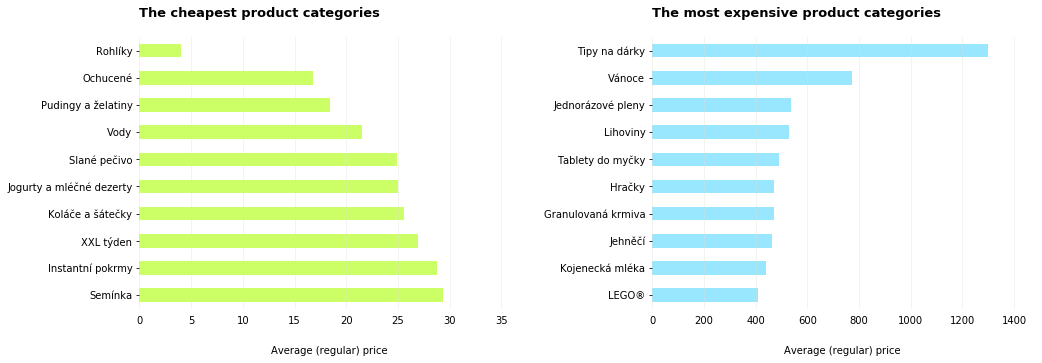

In [22]:
### Plot top 10 categories with the highest/lowest average (regular) price ###

# Define subplots
fig, ax = plt.subplots(ncols = 2, figsize = (16, 5))
plt.subplots_adjust(wspace = 0.35)
plt.style.use('default')

# Plot barcharts
make_cat_barchart(cat_high_price, color = '#99e6ff', xlabel = "Average (regular) price", 
                title = "The most expensive product categories", pos = ax[1])

make_cat_barchart(cat_low_price, color = '#ccff66', xlabel = "Average (regular) price", 
                title = "The cheapest product categories", pos = ax[0])

As we can see, the cheapest product on Rohlik are rohliky. :) Other bakery products are on the list as well, together with other things that people buy on daily basis, such as water or joghurts.

When it comes to the most expensive products, it seems like Rohlik is taking advantage of events such as birthdays or Christmas. Otherwise, for people that are usually shopping on Rohlik.cz, it is expensive to have a child or to drink too much alcohol.

### B) Categories with the best product choice ###

What are the top 10 categories with the best product choice in the analyzed time period (i.e., categories with the highest number of unique products)?

In [23]:
# Obtain top 10 categories with the highest number of unique products
cat_best_choice = data.groupby('Category').nunique().sort_values('Product name', ascending = False)[['Product name']].head(10)

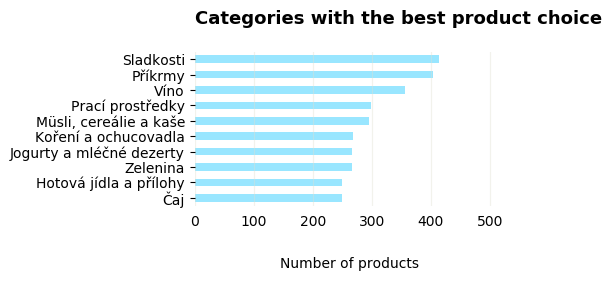

In [24]:
### Plot top 10 categories with the best product choice ###
fig, ax = plt.subplots(ncols = 1, figsize = (4, 2))
plt.style.use('default')

make_cat_barchart(cat_best_choice, color = '#99e6ff', xlabel = "Number of products", 
                  title = "Categories with the best product choice", pos = ax)

The category with largest amount of unique products are Sweets (Candy) with over 400 of products to offer. The second place is taken by Complementary baby food, followed by Wine.

### C) Categories with the highest number of discounted products during the analyzed time period & categories with the best deals (highest average discount in %) ###

In [25]:
# Obtain top 10 categories with the highest number of discounts
cat_most_of_discounts = data.groupby('Category').count().sort_values('Discount in %', ascending = False)[['Discount in %']].round(1).head(10)

# Obtain top 10 categories with the highest average discount in %
cat_best_discount = data.groupby('Category').mean().sort_values('Discount in %', ascending = False)[['Discount in %']].round(1).head(10)

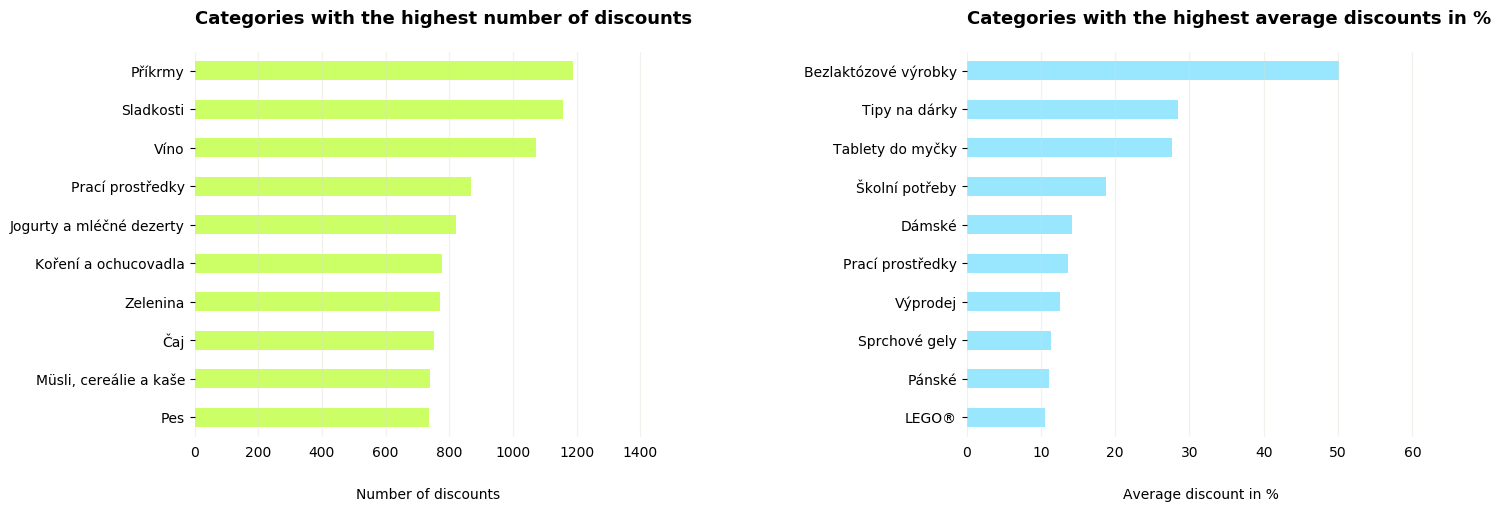

In [26]:
### Plot top 10 categories with the highest number of discounts ###
### Plot top 10 categories with the highest average discounts in % ###

# Define subplots
fig, ax = plt.subplots(ncols = 2, figsize = (16, 5))
plt.subplots_adjust(wspace = 0.65)
plt.style.use('default')

# Plot barcharts
make_cat_barchart(cat_most_of_discounts, color = '#ccff66', xlabel = "Number of discounts", 
                title = "Categories with the highest number of discounts", pos = ax[0])

make_cat_barchart(cat_best_discount, color = '#99e6ff', xlabel = "Average discount in %", 
                title = "Categories with the highest average discounts in %", pos = ax[1])

The categories that are promoted the most are: Complementary baby food, Detergents and Christmas (this is quite funny since the data we are using are from April and still category labeled 'Christmas' is there with more than 250 products on sale). 
However, the number of discounts and the depth of discounts may differ, so we also examine the average depth of promotion. From the chart, we can see that Rohlik promotes the most the lactose-free products, toys or decorations, probably to attract new customers. 
Czech Republic is known to be a country where people are used to high promotions of retailers. Usually, retailers offer at least half of their product sortiment in discounts, and we can see that Rohlik is not an exception.

## 2. PRODUCT ANALYSIS ##

In [27]:
# First, let's define a function that will allow us to make nice plots for product analysis

def make_prod_barchart(data_to_plot, x, color, xlabel, title, pos):
    
    # Plot horizontal barchat
    theplot = data_to_plot.plot(x = x, kind = 'barh', color = color, ax = pos)
    
    # Sort the bars
    theplot.invert_yaxis()
    
    # Remove borders
    [s.set_visible(False) for s in theplot.spines.values()] 
    
    # Remove ticks
    [t.set_visible(False) for t in theplot.get_xticklines()]
    
    # Remove legend
    theplot.get_legend().remove()
    
    # Draw vertical axis lines
    vals = theplot.get_xticks()
    for tick in vals:
        theplot.axvline(x = tick, alpha = 0.4, color = '#e0e0d1', zorder = 1, linewidth = 0.70)
    
    # Set title
    theplot.set_title(title, weight = 'semibold', loc = 'left', size = 13, pad = 20)
    
    # Set x label
    theplot.set_xlabel(xlabel, labelpad = 20, weight = 'medium', size = 10)
    
    # Hide y label
    theplot.yaxis.label.set_visible(False)

### A) The most expensive and the cheapest products on Rohlik.cz ###

Which products were sold for the highest/lowest price during the analyzed time period?

In [28]:
# Obtain top 10 cheapest products (from average price over the analyzed period)
data_means = data.groupby(['Product name'], as_index = False).mean()
prod_low_price = data_means.nsmallest(10, "Regular price")[['Product name', 'Regular price']]

# Obtain top 10 most expensive products
prod_high_price = data_means.nlargest(10, "Regular price")[['Product name', 'Regular price']]

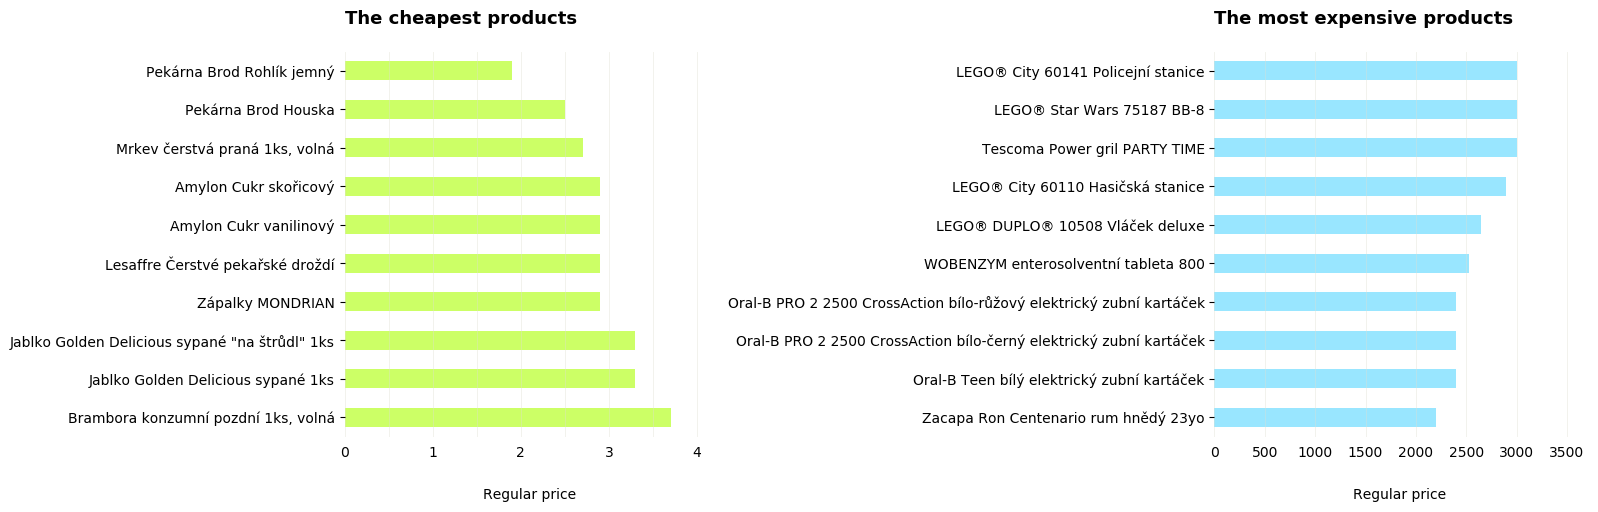

In [29]:
# Define subplots
fig, ax = plt.subplots(ncols = 2, figsize = (16, 5))
plt.subplots_adjust(wspace = 1.35)
plt.style.use('default')

# Plot barcharts
make_prod_barchart(prod_high_price, x = 'Product name', color = '#99e6ff', xlabel = "Regular price", 
                title = "The most expensive products", pos = ax[1])

make_prod_barchart(prod_low_price, x = 'Product name', color = '#ccff66', xlabel = "Regular price", 
                title = "The cheapest products", pos = ax[0])

Not surprisingly, the cheapest products are pastries - white bread rolls (rohlíky), bread buns (housky) and carrots. On the other hand, the most expensive products are LEGO toys or Tescoma grill. 

### B) Products that were offered in the biggest discount (in %) during the analyzed time period ###

In [30]:
# Obtain top 10 products offered in the highest average discount per analyzed time period
mean_discounts = data.groupby(['Product name'], as_index = False).mean()
prod_highest_discount = mean_discounts.nlargest(10, "Discount in %")[['Product name', 'Discount in %']]

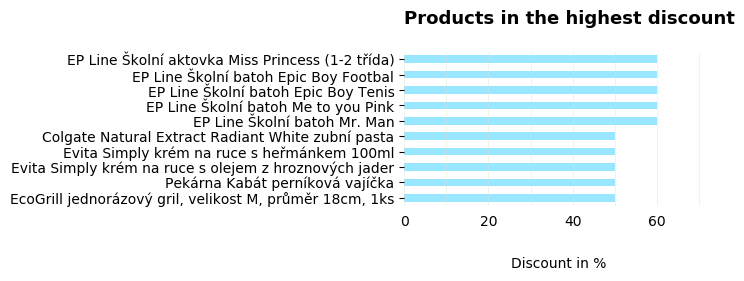

In [31]:
### Plot top 10 products that were offered in the highest discount ###
fig, ax = plt.subplots(ncols = 1, figsize = (4, 2))

make_prod_barchart(prod_highest_discount, x = 'Product name', color = '#99e6ff', xlabel = "Discount in %", 
                title = "Products in the highest discount", pos = ax)

A bit unexpectedly, Rohlik.cz might be the right website for someone who wants to find good deals for buying some non-grocery products such as schoolbags, cosmetics, or a grill.

## 3. PRICING ANALYSIS##

### A) Pricing overview for all products in the whole analyzed time period ###

- **Distribution of regular product prices**

In [32]:
# To better see the distribution of prices we do not want to show outliers --> we filter data to get only 98% quantile
data_to_plot = data[data['Regular price'] < data['Regular price'].quantile(0.98)]

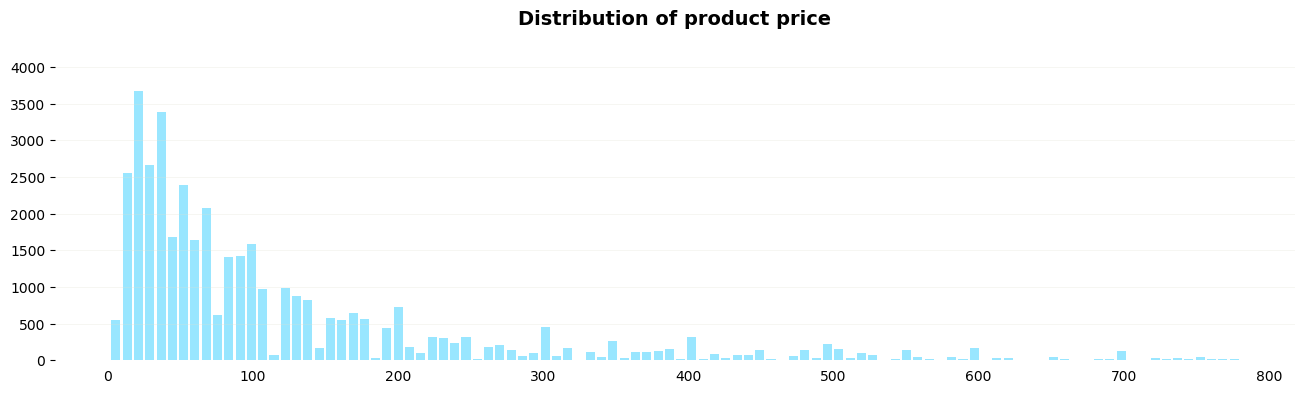

In [33]:
plt.style.use('default')
prices_hist = data_to_plot.hist(column = 'Regular price', bins = 100, grid = False, figsize = (16,4), color = '#99e6ff', rwidth = 0.8)

prices_hist = prices_hist[0]
for x in prices_hist:
    
    # Remove borders, ticks, and legend
    [s.set_visible(False) for s in x.spines.values()] 
    [t.set_visible(False) for t in x.get_xticklines()]
    
    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y = tick, alpha = 0.4, color = '#e0e0d1', zorder = 1, linewidth = 0.5)
    
    # Set title and axis labels
    x.set_title("")
    x.set_title("Distribution of product price", weight = 'semibold', loc = 'center', size = 14, pad = 20)

In [34]:
# Summary statistics of product prices
data[['Regular price']].describe().round(1).transpose()

,count,mean,std,min,25%,50%,75%,max
Regular price,40234.0,141.9,211.5,1.9,34.9,69.9,159.0,2999.0


The histogram of prices together with summary statistics show us that 75% of products are cheaper than 159 CZK, which makes sense as the majority of Rohlik's product portfolio consists of usual groceries and other products that people buy almost everyday. 
The average price on Rohlik is 141.9 CZK.

- **Distribution of discounts (in %)**

In [35]:
# To better see the distribution of discounts we do not want to show all the zeros 
# --> we filter data to get non-zero discounts only 

data_to_plot_d = data[data['Discount in %'] != 0]

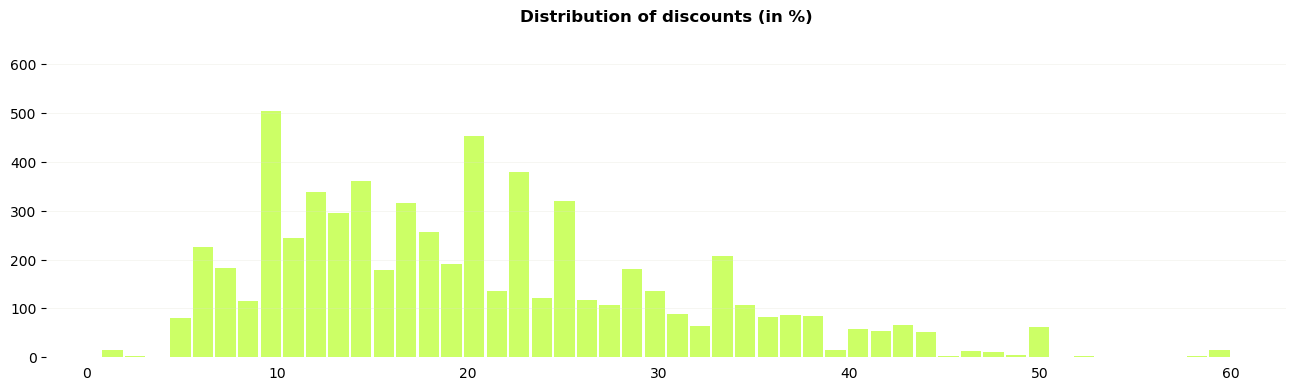

In [36]:
plt.style.use('default')
discount_hist = data_to_plot_d.hist(column = 'Discount in %', bins = 50, grid = False, figsize = (16,4), color = '#ccff66', rwidth = 0.9)

discount_hist = discount_hist[0]
for x in discount_hist:
    
    # Remove borders, ticks, and legend
    [s.set_visible(False) for s in x.spines.values()] 
    [t.set_visible(False) for t in x.get_xticklines()]
    
    # Draw vertical axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y = tick, alpha = 0.4, color = '#e0e0d1', zorder = 1, linewidth = 0.5)
    
    # Set title and axis labels
    x.set_title("")
    x.set_title("Distribution of discounts (in %)", weight = 'semibold', loc = 'center', size = 12, pad = 20)

In [37]:
# Summary statistics of discounts (excluding zero discounts)
data_to_plot_d[['Discount in %']].describe().round(1).transpose()

,count,mean,std,min,25%,50%,75%,max
Discount in %,6324.0,20.3,10.3,0.8,12.4,18.7,26.1,60.0


The average discount over the analyzed time period was 20.3%, while the majority (75%) of discounts stayed below 26.1%. 

The smallest offered discount was 0.8%, however, some discounts were even as high as 60%. This shows that Rohlik is willing to lower some prices significantly in order to attract customers and to stay competitive, which is a common practice also of the majority of other Czech retailers.

In [38]:
# Persistence promo for products
if promo not null in time 1, is there a promo in time 2,3 or 4?  # number of such products, ratio yes/yes+no
OR 
if promo not null in time 2, is there a promo in time 3 or 4?
OR
if promo not null in time 3, is there a promo in time 4?

# we want number of such products, ratio yes/yes+no

SyntaxError: invalid syntax (<ipython-input-38-ddc32faa2456>, line 2)

In [ ]:
# Promotion depth


### B) Pricing overview for selected products, development of prices over time ###

- **Product selection**

As Rohlik.cz sells thousands of different products, we cannot analyze price development in time for all of them. Therefore, we arbitrarily define a shopping basket, i.e., 10 types of products that we believe that people buy very commonly.

Our shopping basket contains:

- Bread
- Butter
- Cheese
- Vegetables (with tomatoes as a representative example) 
- Fruits (with apples and pears as a representative example)
- Milk
- Yoghurt (with Greek type joghurt as a representative example)
- Sweets
- Cosmetics (with natural cosmetics as a representative example)
- Drugstore products (with washing poweder as a representative example)

Such distinction of products can be found in Subcategory column in our data. As for each product subcategory Rohlik.cz offers a selection of multiple brands, again, we cannot look at every single product. Therefore, we randomly select 4 concrete products from each selected subcategory, and then visualize them.

In [53]:
# Shopping basket definition
Subcat_reg = ['Chléb', 'Máslo', 'Sýry', 'Rajčata', 'Jablka a hrušky', 'Čerstvé', 
              'Řecké a řeckého typu', 'Sladkosti', 'Přírodní kosmetika', 'Prací prášky']

# Initialize a dataframe that will contain the random selection of 4 products from each above selected subcategory
sample_products_reg = pd.DataFrame()

for subcat in Subcat_reg:
    
    # Obtain a sample of 4 products from each selected subcategory (from time 1, only where regular price is not null)
    sel_sample = data[(data.Subcategory == subcat) & data['Regular price'].notnull() & (data.Time == 1)].sample(n = 4, random_state = 18)                                                                               
    
    # Append to the full dataframe
    sample_products_reg = sample_products_reg.append(sel_sample[['Subcategory', 'Product name']])  

- **Analysis of development of regular prices in time**

In [54]:
# Define a function that will plot price development in time

# Number of time periods (needed for x tick labels)
n_of_times = range(1, n_of_weeks+1)

# Price plot function
def price_plot(sample_data, pricetype, subcateg):

    # Take one subcategory from our previously selected subcategories
    sample_subcateg = sample_data[sample_data['Subcategory'] == subcateg]

    # Get list of those 4 random products in that subcategory
    prod_list = list(sample_subcateg['Product name'])
    
    # Settings for plotting
    fig, ax = plt.subplots(1, 4, figsize = (14, 2))
    plt.subplots_adjust(wspace = 0.5)
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('Dark2')
    
    for i, prod in enumerate(prod_list):
        
        # From original dataframe, get all data for each randomly selected product in given subcategory
        prod_subset = data[data['Product name'] == prod]
        
        # Plot the lineplot for that product
        line_plot = prod_subset.plot(x = 'Time', y = pricetype, kind = 'line', color = palette(i), linewidth = 2.5, ax = ax[i])

        # Remove top and right border
        line_plot.spines['right'].set_visible(False)
        line_plot.spines['top'].set_visible(False)

        # Remove legend
        line_plot.get_legend().remove()

        # Set x ticks labels
        line_plot.set(xticks = n_of_times, xticklabels = list(n_of_times))
        
        line_plot.set_ylabel(pricetype, fontsize = 9)

        # Set title
        line_plot.set_title(prod, loc = 'left', size = 8, pad = 20)
        
    # general title for the 4 products (i.e., one subcategory)
    plt.suptitle(subcateg, fontsize = 13, fontweight='semibold', y  = 1.3)

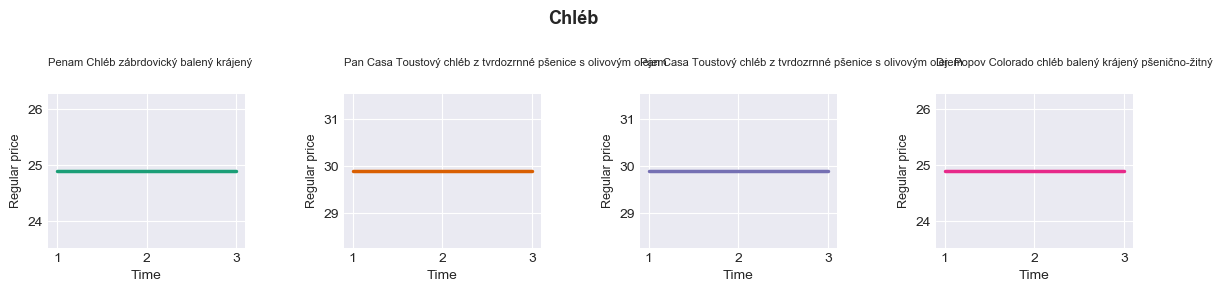

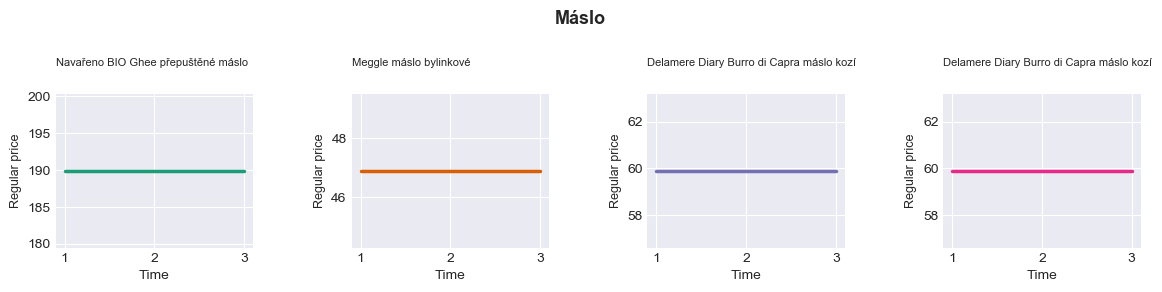

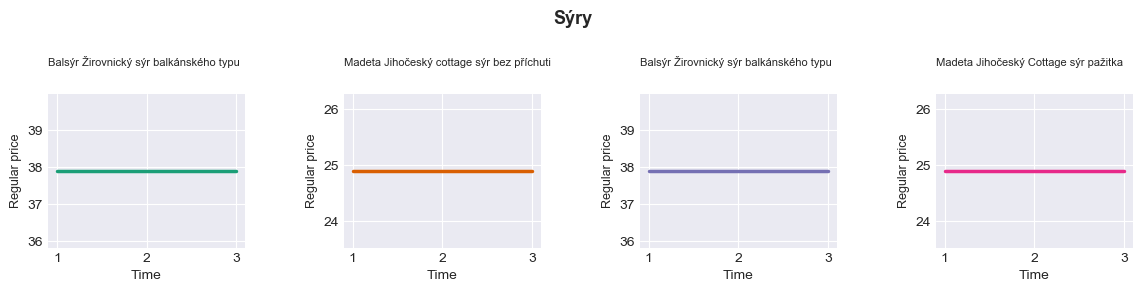

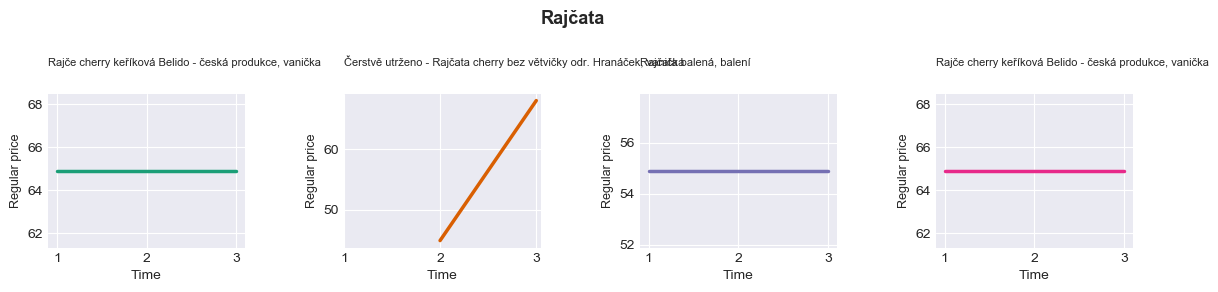

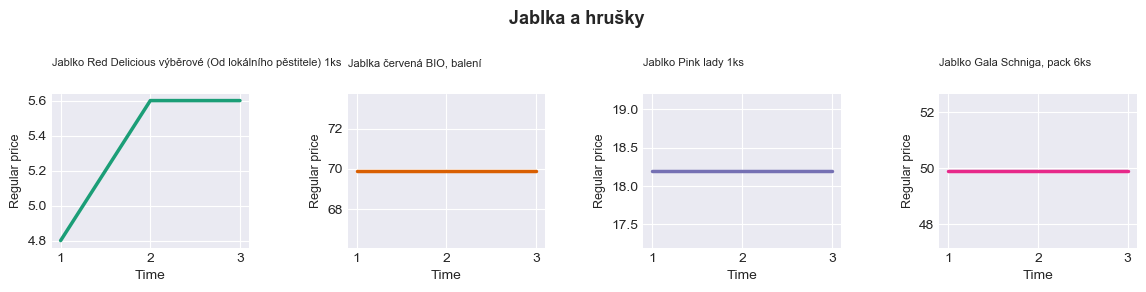

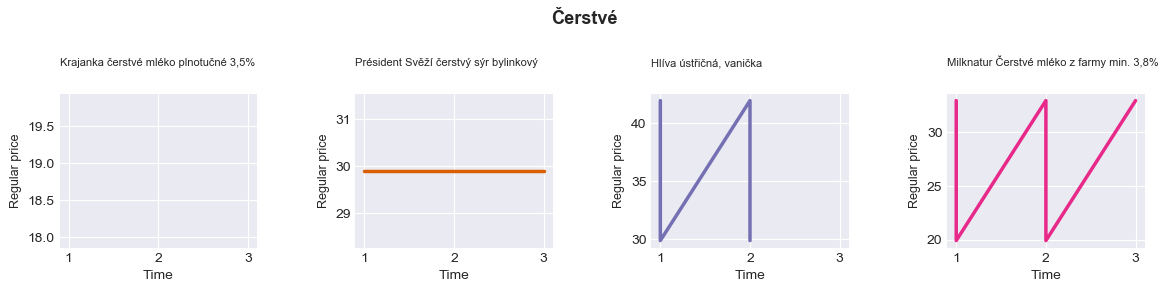

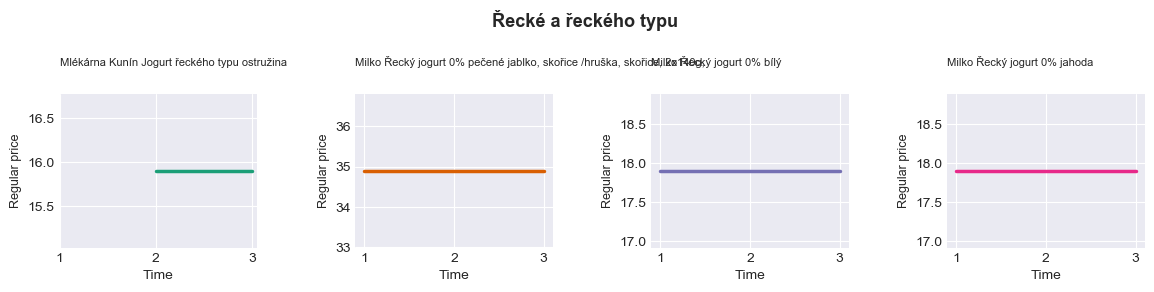

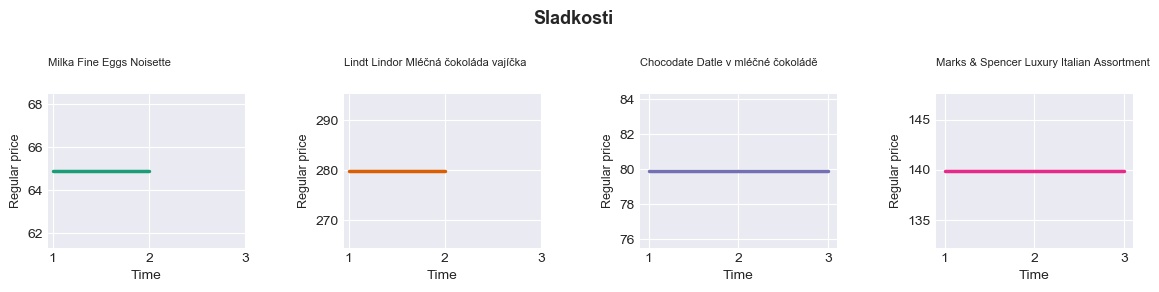

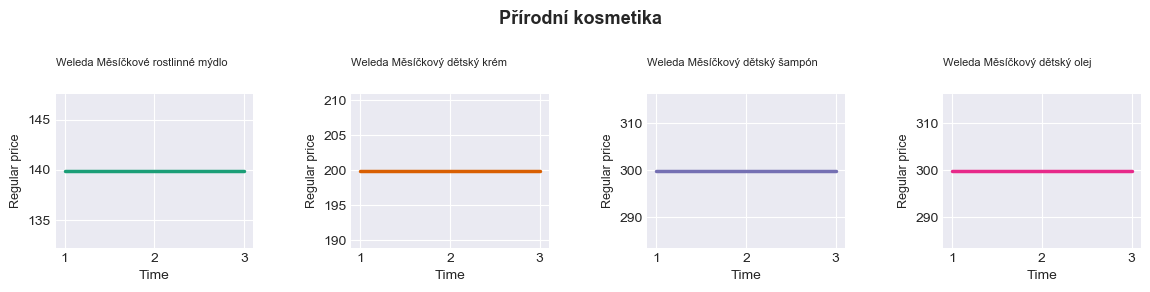

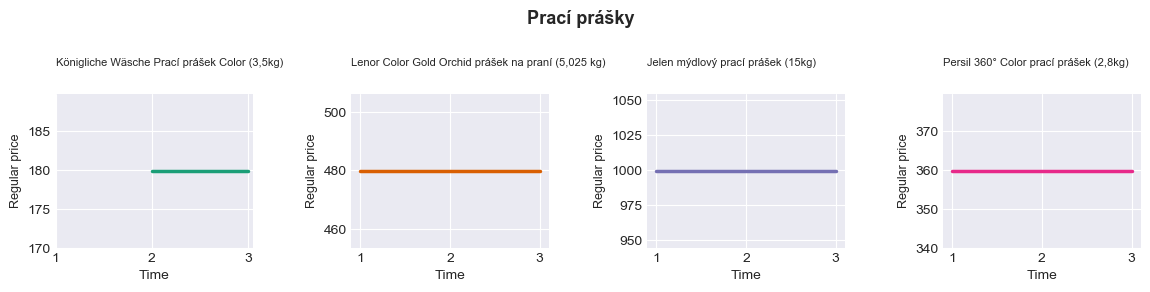

In [55]:
#Run twice if the first plot set has ugly background

for subcat in Subcat_reg:
    plt.style.use('seaborn-darkgrid')
    price_plot(sample_products_reg, 'Regular price', subcat)

The price plots show that regular prices of most of the products stayed the same over the analyzed period. 

Two price drops (with one of them being quite high) can be seen for tomatoes. This is a product type for which the price fluctuations might be reasonably expected as it is highly depended on current harvest and availability of supplies. 

Moreover, there was a price increase in butter category, where it is also not surprising as the butter price has been high for the last couple of months, and it is still rather slighly rising than decreasing.

- **Analysis of development of promo prices in time**

In order to analyze the development of promo prices in time, we need to define a new subset of products, as hardly any of those previously defined products were offered in discount. 

To be sure that there are some discounts in our selected subcategories, we do not specify the typical shopping basket anymore, but we rather choose the subcategories with a high number of discounts. We select the names of such subcategories based on the data table "many_discounts", which is defined in the following step, but which is not explicitly shown as it takes a lot of space.

In [75]:
many_discounts = data.groupby(['Category','Subcategory']).count().sort_values('Discount in %', ascending = False)[['Discount in %']].round(1).head(35)

In [139]:
# select only products that have promo price in all 3 periods, so that graphs are well defined
prod = data[data['Promo price'].notnull()].groupby('Product name').count()[['Time']].reset_index()
all_promo = prod[prod.Time == 3]

to_plot = data[data['Product name'].isin(all_promo['Product name'])]

to_plot.Subcategory.unique()

In [155]:
# Select subcategories
Subcat_promo = ['Zubní pasty', 'Hračky', '100% džusy', 'Bílá', 'Ležáky do 12°', 'Zrnková káva', 'Prací prášky', 'Čištění koupelny'] 

# Initialize a dataframe that will contain the random selection of 4 products from each above selected subcategory
sample_products_promo = pd.DataFrame()

for subcat in Subcat_promo:
    
    # Obtain a sample of 4 products from each selected subcategory (from time 1, only where promo price is not null)
    sel_sample = to_plot[(to_plot.Subcategory == subcat) & to_plot['Promo price'].notnull()].sample(n = 4, random_state = 2)                                                                               
    
    # Append to the full dataframe
    sample_products_promo = sample_products_promo.append(sel_sample[['Subcategory', 'Product name']]) 

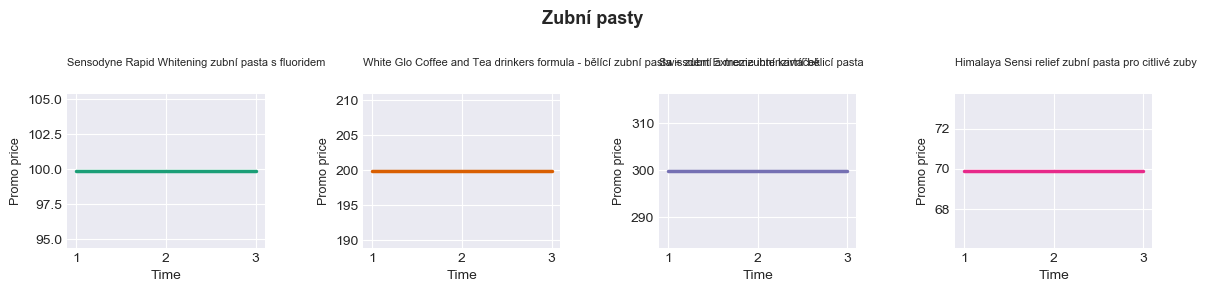

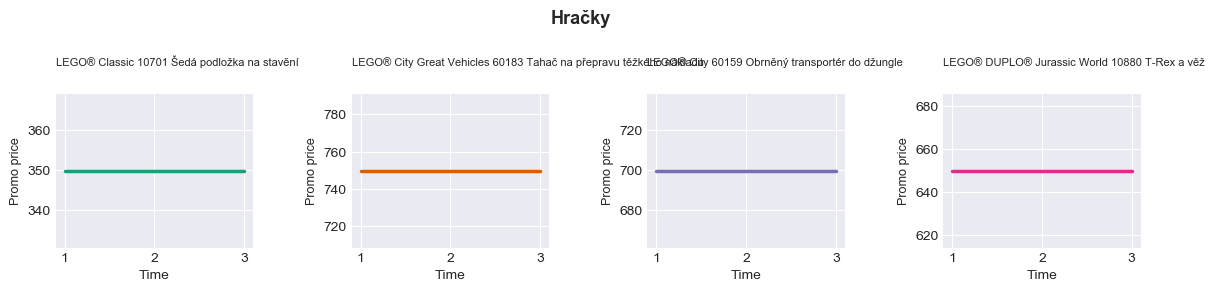

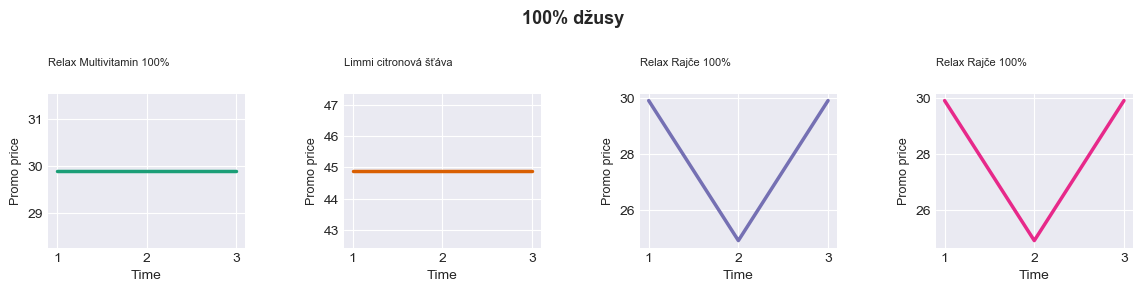

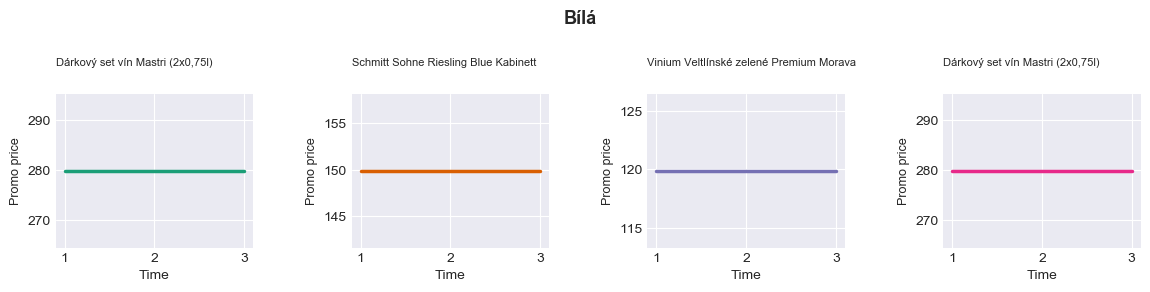

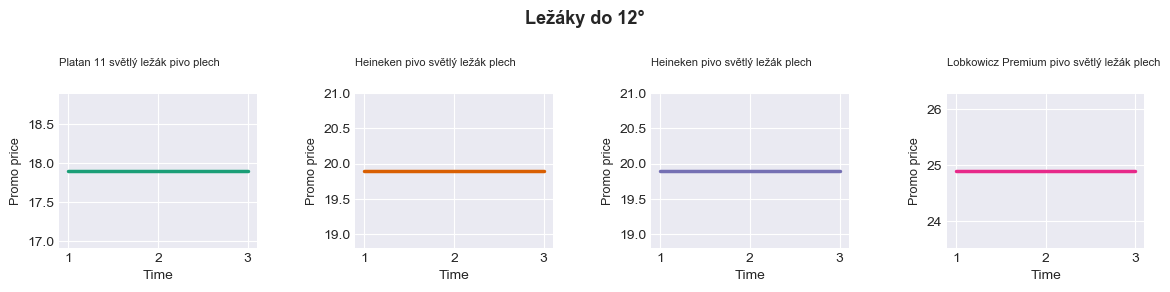

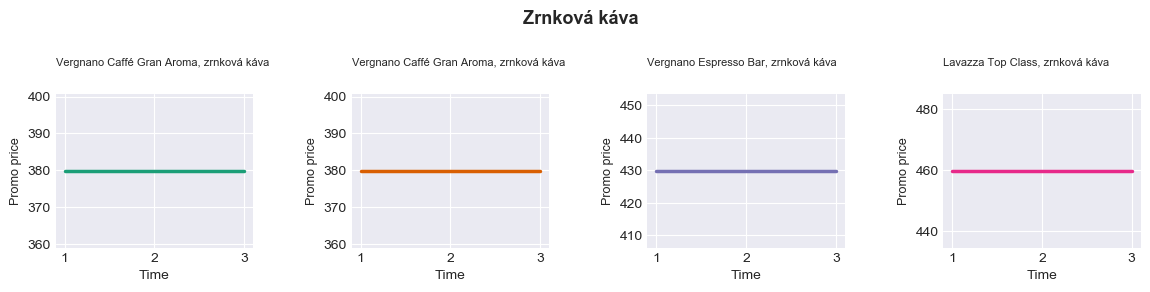

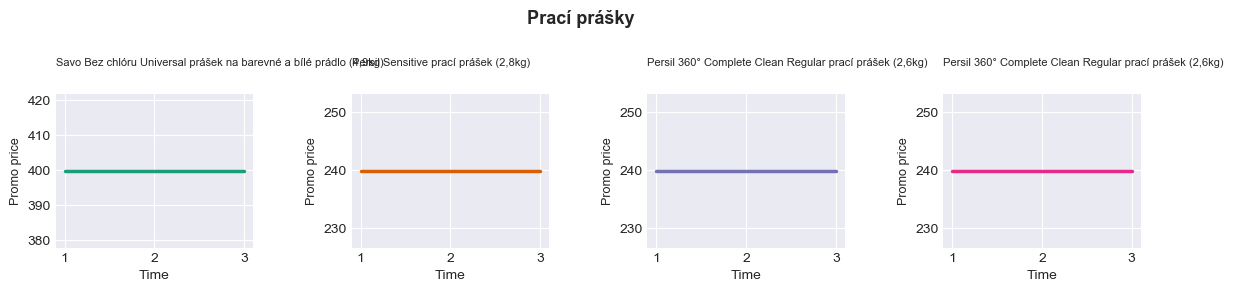

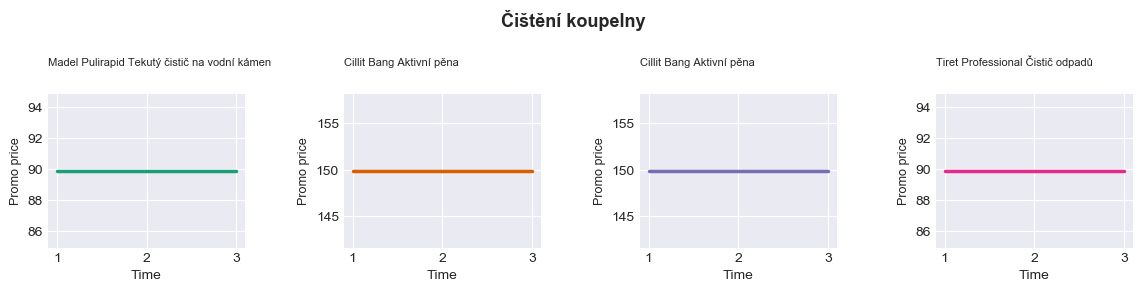

In [156]:
for subcat in Subcat_promo:
    
    plt.style.use('seaborn-darkgrid')
    price_plot(sample_products_promo, 'Promo price', subcat)